## Tokenizing:

In [42]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser('http://localhost:9001')
with open(r'H:\HLT\zh-Education.tok','w',encoding="utf-8") as cf:
    with open(r'G:\NLP\zh-Education.txt','r',encoding="utf-8") as f:
        for _ , line in enumerate(f):
            cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [46]:
from nltk.parse import CoreNLPParser
parser = CoreNLPParser('http://localhost:9001')
with open(r'H:\HLT\en-Education.tok','w',encoding="utf-8") as cf:
    with open(r'G:\NLP\en-Education.txt','r',encoding="utf-8") as f:
        for _ , line in enumerate(f):
            cf.write((' '.join(list(parser.tokenize(line)))) + '\n')

In [1]:
import unicodedata
import re

# Preprocessing data
def unicodeToAscii(s): 
    # Turn a Unicode string to plain ASCII
    # refer to https://stackoverflow.com/a/518232/2809427
    return ''.join( c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def en_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"[^a-zA-Z0-9,.!?]+", r" ", s)
    s = s.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    s = '<start> ' + s + ' <end>'
    return s

def zh_normalizeString(s):
    # lowercase, trim and remove non-letter characters
    s = s.lower().strip()
    s = re.sub(r"[^a-zA-Z0-9\u4e00-\u9fa5！？，。]+", r" ", s)
    s = s.strip()

    return s

In [2]:
import io

# Create input/target dataset
def create_dataset(path_zh, path_en, num_examples=None):
    chinese_sentences = io.open(path_zh, encoding='UTF-8').read().strip().split('\n')
    english_sentences = io.open(path_en, encoding='UTF-8').read().strip().split('\n')
    chinese_sentences = [zh_normalizeString(s) for s in chinese_sentences[:num_examples]]
    english_sentences = [en_normalizeString(s) for s in english_sentences[:num_examples]]  
    return chinese_sentences, english_sentences

In [3]:
import keras.preprocessing.text as T
import keras.preprocessing.sequence as S

# Tokening
def tokenize(lang):
    lang_tokenizer = T.Tokenizer(filters='')
    lang_tokenizer.fit_on_texts(lang)
    tensor = lang_tokenizer.texts_to_sequences(lang)
    
    return tensor, lang_tokenizer

Using TensorFlow backend.


In [4]:
# Transform word to index
def load_dataset(path_to_file_zh, path_to_file_en, num_examples=None):
    inp_lang, targ_lang  = create_dataset(path_to_file_zh, path_to_file_en, num_examples)
    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [5]:
path_to_file_zh = r'H:\HLT\zh-Education.tok'
path_to_file_en = r'H:\HLT\en-Education.tok'

# Try experimenting with the size of that dataset
num_examples = 450#450000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file_zh, path_to_file_en, num_examples)

# Creating a reverse dictionary (index to word)
index_word_inp = dict(map(reversed, inp_lang.word_index.items()))
index_word_targ = dict(map(reversed, targ_lang.word_index.items()))

In [6]:
# Input tokens for encoder zero padded
num_encoder_tokens = len(inp_lang.word_index) + 1
# Input tokens for decoder zero padded
num_decoder_tokens = len(targ_lang.word_index) + 1
print('Number of input tokens for encoder/decoder with zero padding: {}, {}'.format(num_encoder_tokens, num_decoder_tokens))

Number of input tokens for encoder/decoder with zero padding: 3166, 2800


In [7]:
import numpy as np

# Map word to fixed-length dense and continuous-valued vector with pre-trained Fasttext word embedding
def word2vec(trained_vector_path):
    word2vec_dict = {}

    with open(trained_vector_path, 'r', encoding='utf-8') as f:    
        for line in (f):
            array = line.strip().split(" ")
            word2vec_dict[array[0]] = list(map(float, array[1:])) # {word: vectors}

    return word2vec_dict

# Generate embedding vectors for <start> and <end> token
def initSpecialToken(vector_size, seed):
    np.random.seed(seed)
    return np.random.rand(vector_size)

# Custumize the embedding vectors for the dataset with pre-trained embedding word vectors
def get_embedding_matrix(num_tokens, trained_vector_path, vector_size):
    trained_word_vec = word2vec(trained_vector_path)
    print('number of trained word vector: {}:{}'.format(trained_vector_path, len(trained_word_vec)))

    embedding_matrix = np.zeros(num_tokens, vector_size)

    for word, idx in word2index.items():
        word_vec = trained_word_vec.get(word)
        if word_vec is not None:
            embedding_matrix[idx] = word_vec
    return embedding_matrix

In [ ]:
import gzip
import os
import tarfile
import wget

# Download pre-trained Fasttext word embeddin
wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.vec.gz",out = r"G:\NLP\fasttext\cc.en.300.vec.gz")
wget.download("https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.zh.300.vec.gz",out = r"G:\NLP\fasttext\cc.zh.300.vec.gz")


# Uncompressing download files
def un_gz(file_name):
    """ungz zip file"""
    f_name = file_name.replace(".gz", "")
    g_file = gzip.GzipFile(file_name)
    open(f_name, "w+").write(g_file.read())
    g_file.close()
    
%cd "G:\NLP\fasttext\"
un_gz("cc.en.300.vec.gz")
un_gz("cc.zh.300.vec.gz")

In [ ]:
import numpy as np

vector_size = 300
trained_vector_paths = (r'G:\NLP\fasttext\cc.zh.300.vec', r'G:\NLP\fasttext\cc.en.300.vec')

# Creating input embedding vectors
input_emb_matrix = get_embedding_matrix(trained_vector_paths[0], vector_size, num_encoder_tokens)
# Save input embedding vectors
np.save(r'H:\HLT\Embedding_Matrix\input_emb_matrix', input_emb_matrix)

In [ ]:
# Creating output embedding vectors and specify the <start>, <end> token
output_emb_matrix = get_embedding_matrix(trained_vector_paths[1], vector_size, num_decoder_tokens)
start_token_vec = initSpecialToken(vector_size, 0) #'<start>'
end_token_vec = initSpecialToken(vector_size, 1) # '<end>'
output_emb_matrix[targ_lang.word_index['<start>']] = start_token_vec
output_emb_matrix[targ_lang.word_index['<end>']] = end_token_vec
# Save output embedding vectors
np.save(r'H:\HLT\Embedding_Matrix\output_emb_matrix', output_emb_matrix)

In [8]:
# Load input/output embedding vectors
input_emb_matrix, output_emb_matrix= np.load(r'H:\HLT\Embedding_Matrix\input_emb_matrix.npy'), np.load(r'H:\HLT\Embedding_Matrix\output_emb_matrix.npy')
print('Embedding-matrix shape: {}, {}'.format(input_emb_matrix.shape, output_emb_matrix.shape))

Embedding-matrix shape: (145824, 300), (210721, 300)


In [9]:
from sklearn.model_selection import train_test_split
import random

# Shuffle the data
def shuffle(input_tensor, target_tensor): 
    dataset = list(zip(input_tensor, target_tensor))
    random.shuffle(dataset)
    return list(zip(*dataset))[0], list(zip(*dataset))[1]

# Train - Test Split
input_tensor, target_tensor = shuffle(input_tensor, target_tensor)
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Number of Training/validation samples
train_samples = len(input_tensor_train)
val_samples = len(input_tensor_val)
print('Number of samples for Training/Validation: {}, {}'.format(train_samples, val_samples))

Number of samples for Training/Validation: 360, 90


In [10]:
# Max length of input/target sentences
max_length_inp = max([len(sent) for sent in input_tensor])# 264 for whole dataset
max_length_targ = max([len(sent[:-1]) for sent in target_tensor])# 239 for whole dataset
print('Max length of input/target sentences: {}, {}'.format(max_length_inp, max_length_targ))

Max length of input/target sentences: 49, 47


In [11]:
from keras.utils import to_categorical
import numpy as np

# Creat a batch generator
def generate_batch(input_tensor, target_tensor, batch_size = 128):
    #zero padding all sequences
    encoder_input_tensor = S.pad_sequences(input_tensor,padding='post', maxlen = max_length_inp)
    # decoder input sequence does not include the <end> token
    decoder_input_tensor = S.pad_sequences([s[:-1] for s in target_tensor],padding='post', maxlen = max_length_targ)
    # decoder target sequence (one hot encoded) does not include the <START> token, Offset by one timestep
    decoder_target_tensor = np.array([to_categorical(t,len(targ_lang.word_index) + 1) for t in S.pad_sequences([s[1:] for s in target_tensor],padding='post', maxlen = max_length_targ)])

    # Generate a batch of data
    while True:
        for i in range(0, len(input_tensor), batch_size):
            encoder_input_batch = encoder_input_tensor[i:i + batch_size]
            decoder_input_batch = decoder_input_tensor[i:i + batch_size]
            decoder_target_batch = decoder_target_tensor[i:i + batch_size]
            yield([encoder_input_batch, decoder_input_batch], decoder_target_batch)

In [12]:
from keras.models import Model
from keras.layers import Activation, dot, Input, Embedding, LSTM, GRU, Dense, Concatenate, TimeDistributed, Bidirectional, Dropout

latent_dim = 300
# Set up the encoder
encoder_inputs = Input(shape=(max_length_inp,))
enc_emb =  Embedding(num_encoder_tokens, latent_dim, weights = [input_emb_matrix[:num_encoder_tokens]], trainable = False)(encoder_inputs)
#enc_emb = Dropout(0.1)(enc_emb)
encoder_gru = Bidirectional(GRU(latent_dim, return_sequences=True, return_state=True))
encoder_outputs, encoder_fwd_states, encoder_back_states = encoder_gru (enc_emb)
encoder_states = Concatenate(axis=-1)([encoder_fwd_states, encoder_back_states])

In [13]:
from keras.layers import concatenate
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))
# Embedding with with pre-trained embedding word vectors
dec_emb_layer =  Embedding(num_decoder_tokens, latent_dim, weights = [output_emb_matrix[:num_decoder_tokens]], trainable = False)
dec_emb = dec_emb_layer(decoder_inputs)
#dec_emb = Dropout(0.1)(dec_emb)
# We set up our decoder to return full output sequences, and to return internal states as well. We don't use the return states in the training model, but we will use them in inference.
decoder_gru = GRU(latent_dim*2, return_sequences=True, return_state=True)
decoder_outputs, decoder_states = decoder_gru(dec_emb, initial_state=encoder_states)

# Attention layer
# (batch_size, max_length_inp, latent_dim) dot (latent_dim, latent_dim) => (batch_size, max_length_inp, latent_dim)
enc_dense = Dense(latent_dim*2, use_bias = False)
encoder = enc_dense(encoder_outputs)
# (batch_size, 1, latent_dim) dot (latent_dim, latent_dim) => (batch_size, 1, latent_dim)
dec_dense = Dense(latent_dim*2, use_bias = False)
decoder = dec_dense(decoder_outputs)
# (batch_size, 1, latent_dim) dot (batch_size, max_length_inp, latent_dim) => (batch_size, 1, max_length_inp)
score = dot([decoder, encoder], axes=[2, 2])
# (batch_size, 1, max_length_inp) dot (max_length_inp, max_length_inp) => (batch_size, 1, max_length_inp)
score_dense = Dense(max_length_inp, activation='tanh')
score = score_dense(score)
attention_weights = Activation('softmax')(score)

# Context vector
# (batch_size, 1, max_length_inp) dot (batch_size, max_length_inp, latent_dim) => (batch_size, 1, latent_dim)
context = dot([attention_weights, encoder], axes = [2,1])
# (batch_size, 1, latent_dim)
decoder_combined_context = concatenate([context, decoder_outputs])
atten_dense = Dense(latent_dim*2, use_bias = False, activation='tanh')
attention_vector = atten_dense(decoder_combined_context)

decoder_dense = Dense(num_decoder_tokens, activation='softmax')
#dense_time = TimeDistributed(decoder_dense)
#decoder_outputs = dense_time(decoder_outputs)
decoder_outputs = decoder_dense(attention_vector)

In [14]:
# Define the model that takes encoder and decoder input to output decoder_outputs
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 49, 300)      949800      input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 49, 600), (N 1081800     embedding_1[0][0]                
__________________________________________________________________________________________________
embedding_

In [15]:
!apt install graphviz
!pip install pydot pydot-ng

'apt' 不是内部或外部命令，也不是可运行的程序
或批处理文件。


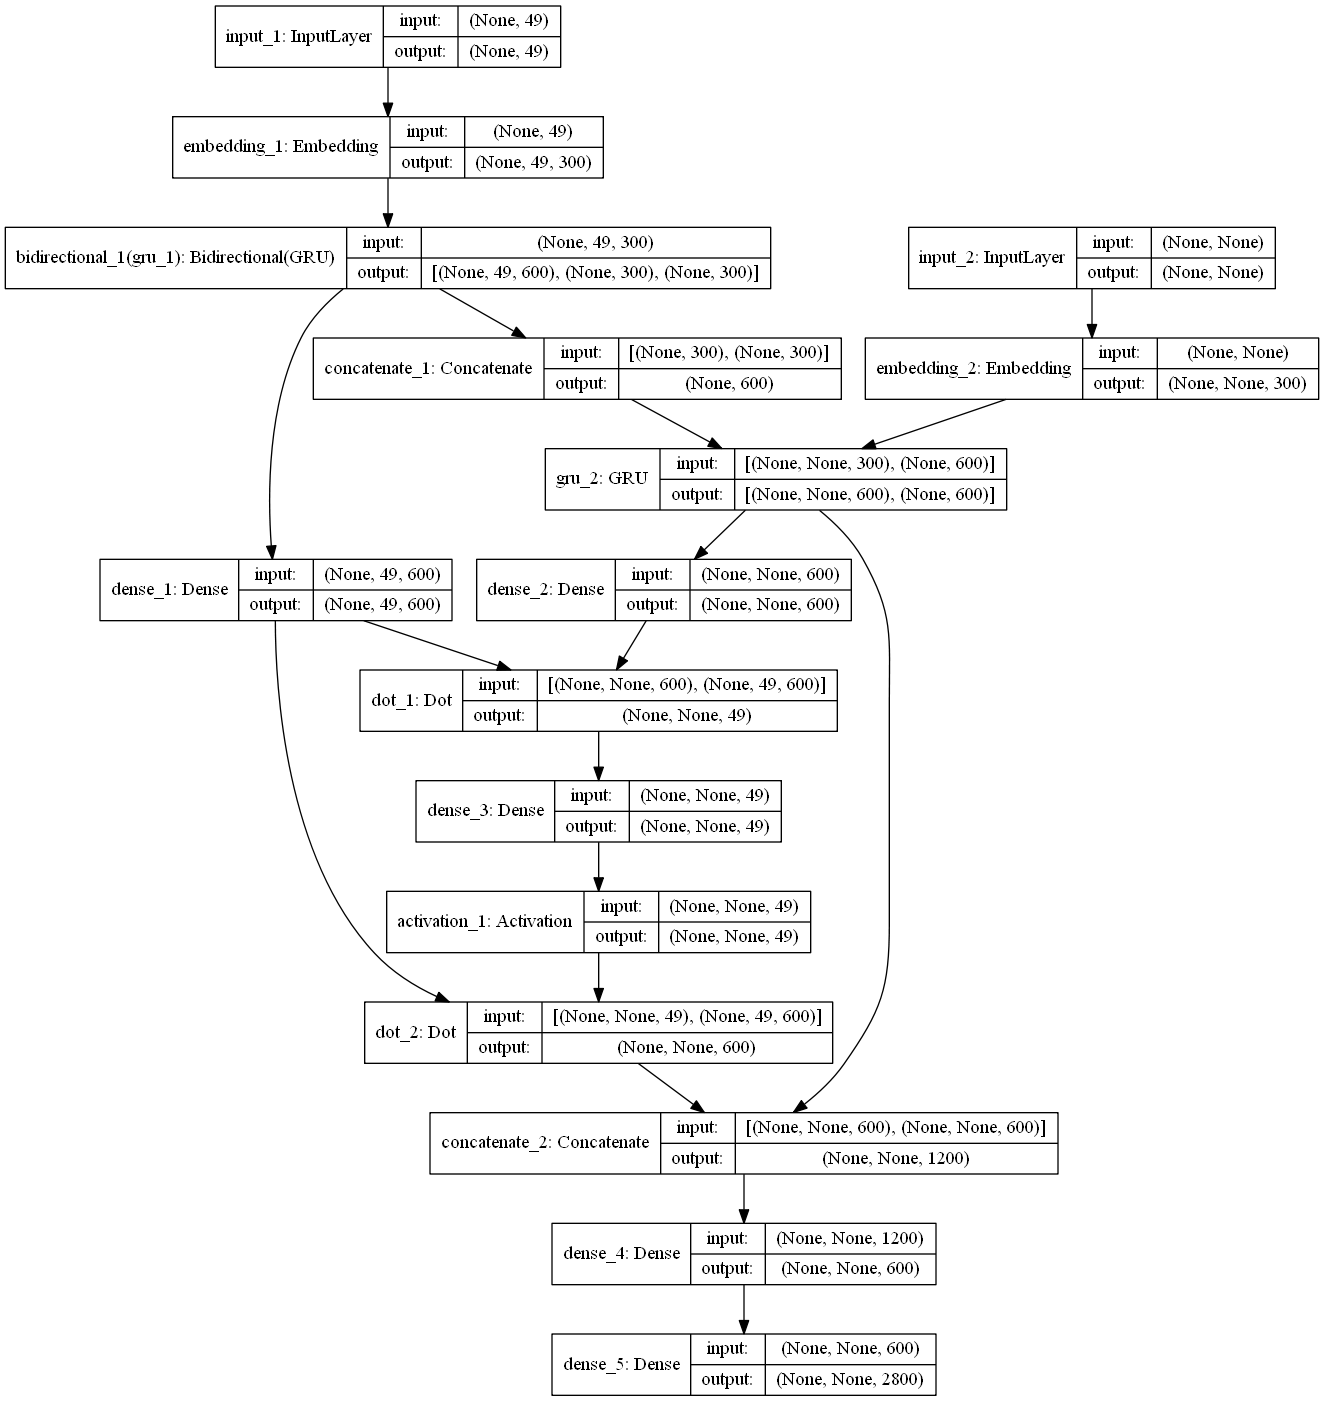

In [16]:
from keras.utils import plot_model
from IPython.display import Image

plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image(retina=True, filename='model.png')

In [17]:
# Start training
batch_size = 20#128
epochs = 50#100
history = model.fit_generator(generator = generate_batch(input_tensor_train, target_tensor_train, batch_size = batch_size),
                    steps_per_epoch = train_samples//batch_size,
                    epochs=epochs,
                    validation_data = generate_batch(input_tensor_val, target_tensor_val, batch_size = batch_size),
                    validation_steps = val_samples//batch_size)

Epoch 1/50
18/18 [==============================] - 35s 2s/step - loss: 3.9294 - acc: 0.4827 - val_loss: 3.5887 - val_acc: 0.5013
Epoch 2/50
18/18 [==============================] - 30s 2s/step - loss: 3.2175 - acc: 0.5294 - val_loss: 3.6804 - val_acc: 0.5140
Epoch 3/50
18/18 [==============================] - 30s 2s/step - loss: 3.1009 - acc: 0.5408 - val_loss: 3.6009 - val_acc: 0.5195
Epoch 4/50
18/18 [==============================] - 30s 2s/step - loss: 3.0173 - acc: 0.5456 - val_loss: 3.5874 - val_acc: 0.5374
Epoch 5/50
18/18 [==============================] - 30s 2s/step - loss: 2.9260 - acc: 0.5546 - val_loss: 3.5857 - val_acc: 0.5374
Epoch 6/50
18/18 [==============================] - 31s 2s/step - loss: 2.8514 - acc: 0.5569 - val_loss: 3.6611 - val_acc: 0.5399
Epoch 7/50
18/18 [==============================] - 32s 2s/step - loss: 2.7698 - acc: 0.5609 - val_loss: 3.7166 - val_acc: 0.5356
Epoch 8/50
18/18 [==============================] - 30s 2s/step - loss: 2.7045 - acc: 0.56

H:\Anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


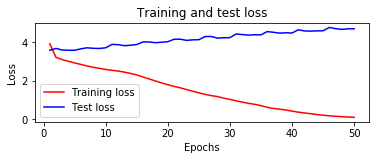

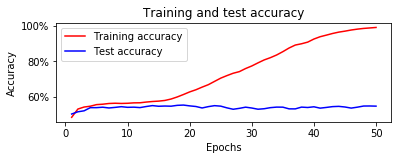

In [18]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']
epochs = range(1, len(val_loss_values) + 1)
import matplotlib.pyplot as plt
%matplotlib inline 

plt.subplot(211)
plt.plot(epochs, history.history['loss'], 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Test loss')
plt.title('Training and test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()

plt.subplot(212)
plt.plot(epochs, history.history['acc'], 'r', label='Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label='Test accuracy')
plt.title('Training and test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

In [ ]:
# Save weights
model.save_weights('NMT_Bi_GRU_Atten_Emb_50_epochs.h5')
# Load weights
model.load_weights('NMT_Bi_GRU_Atten_Emb_50_epochs.h5')

In [21]:
# Encode the input sequence to get the "Context vectors"
encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_states])
# Decoder setup
decoder_state_input = Input(shape=(latent_dim*2,))
# Get the embeddings of the decoder sequence
dec_emb2= dec_emb_layer(decoder_inputs)
# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, decoder_states2 = decoder_gru(dec_emb2, initial_state=decoder_state_input)

# Attention layer
# (batch_size, max_length_inp, latent_dim) dot (latent_dim, latent_dim) => (batch_size, max_length_targ, latent_dim)
encoder2 = enc_dense(encoder_outputs)
# (batch_size, 1, latent_dim) dot (latent_dim, latent_dim) => (batch_size, 1, latent_dim)
decoder2 = dec_dense(decoder_outputs2)
# (batch_size, 1, latent_dim) dot (batch_size, max_length_inp, latent_dim) => (batch_size, 1, max_length_inp)
score2 = dot([decoder2, encoder2], axes=[2, 2])#attention = dot([decoder, encoder], axes=[2, 2])
# (batch_size, 1, max_length_inp) dot (max_length_inp, max_length_inp) => (batch_size, 1, max_length_inp)
score2 = score_dense(score2)
attention_weights2 = Activation('softmax')(score2)

# Context vector
# (batch_size, 1, max_length_inp) dot (batch_size, max_length_inp, latent_dim) => (batch_size, 1, latent_dim)
context2 = dot([attention_weights2, encoder2], axes = [2,1])
# (batch_size, 1, latent_dim)
decoder_combined_context2 = concatenate([context2, decoder_outputs2])
attention_vector2 = atten_dense(decoder_combined_context2)

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(attention_vector2)
# Final decoder model
decoder_model = Model(
     [encoder_inputs] + [decoder_inputs] + [decoder_state_input],
     [decoder_outputs2] + [decoder_states2])

In [22]:
# Encoder model summary
encoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 49, 300)      949800      input_1[0][0]                    
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 49, 600), (N 1081800     embedding_1[0][0]                
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 600)          0           bidirectional_1[0][1]            
                                                                 bidirectional_1[0][2]            
Total para

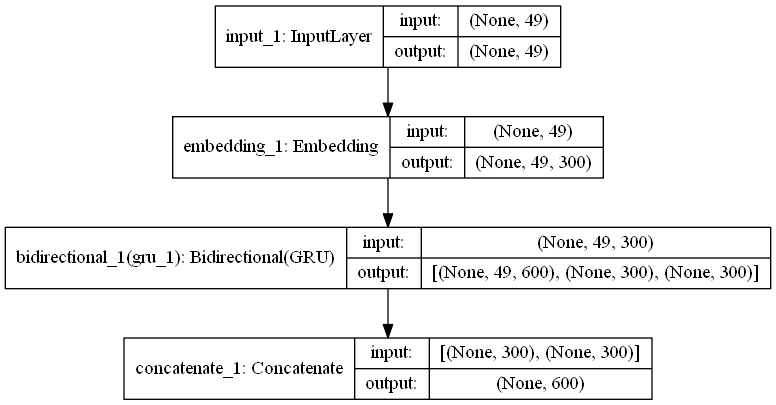

In [23]:
plot_model(encoder_model, show_shapes=True, show_layer_names=True, to_file='encoder_model.png')
Image(retina=True, filename='encoder_model.png')

In [24]:
# Decoder model summary
decoder_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 49)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 300)    840000      input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 600)          0                                            
__________________________________________________________________________________________________
embedding_

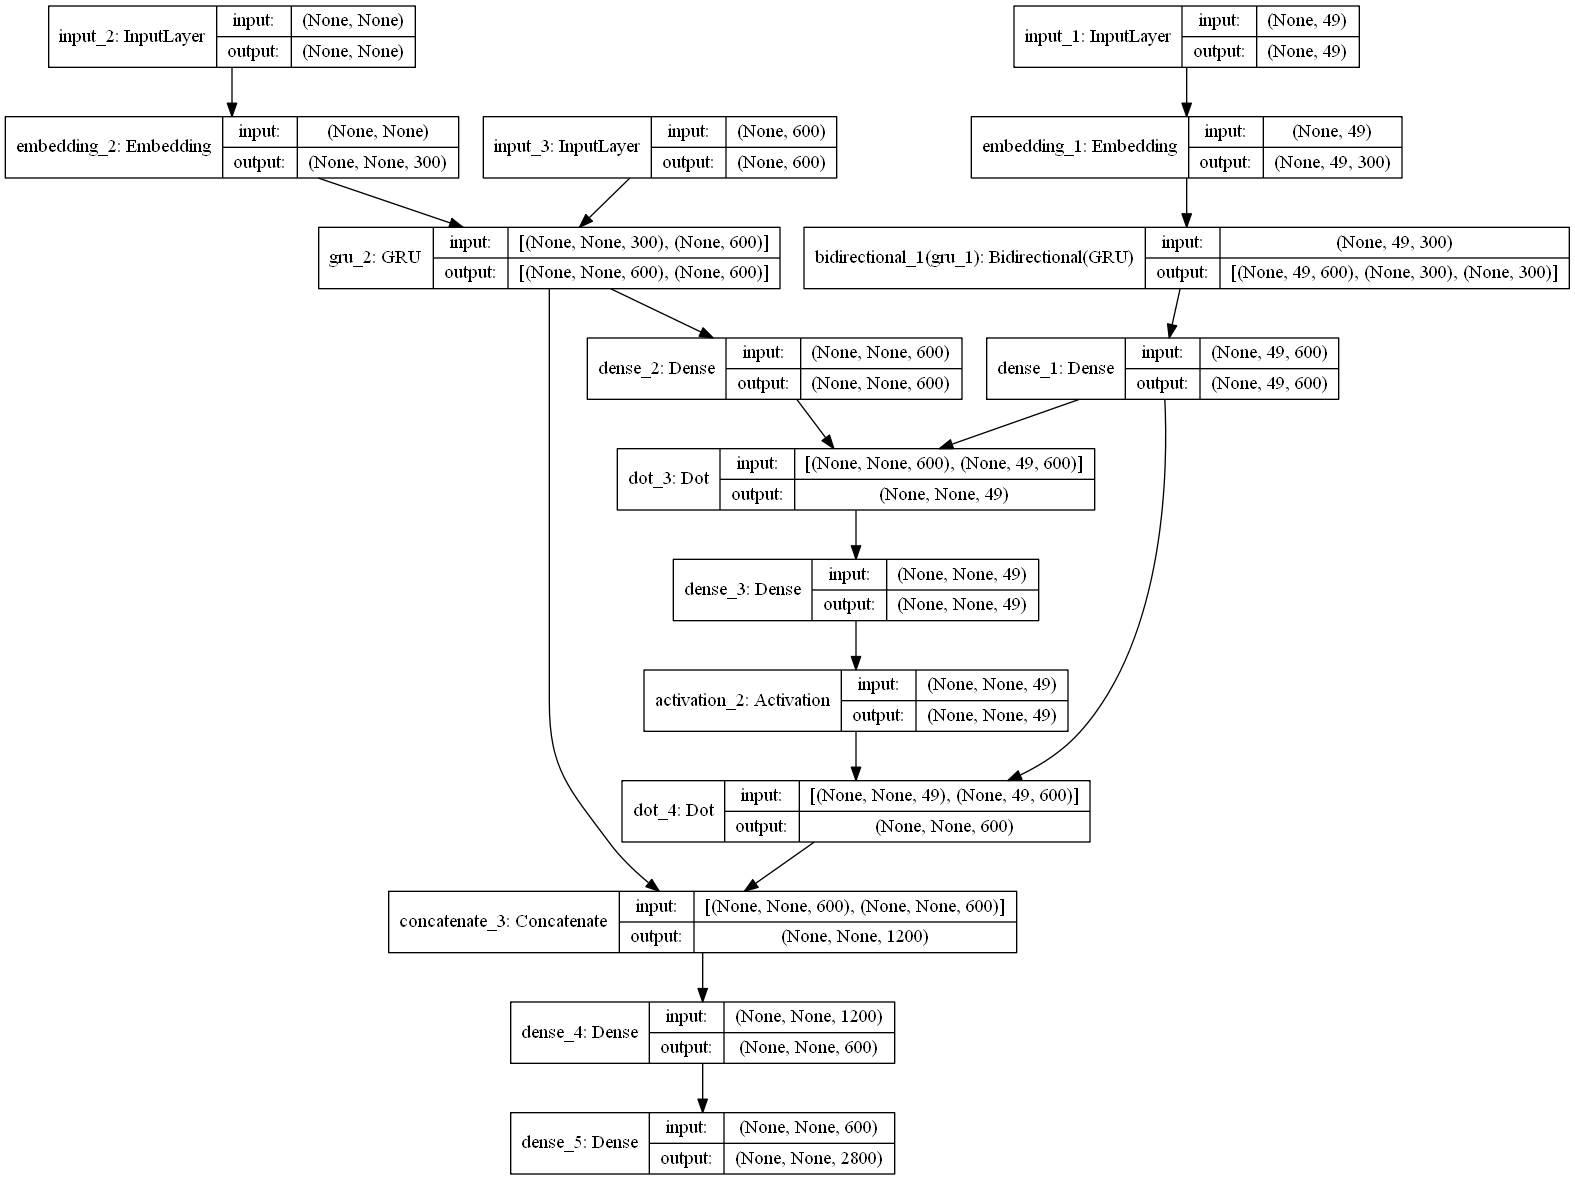

In [25]:
plot_model(decoder_model, show_shapes=True, show_layer_names=True, to_file='decoder_model.png')
Image(retina=True, filename='decoder_model.png')

In [26]:
def decode_sequence_with_k_beam_search(input_seq, k = 2):
    # Encode the input as state vectors.
    [encoder_outputs, states_value] = encoder_model.predict(input_seq)
    #print("input_seq",input_seq.shape, states_value.shape)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of 
    #target sequence with the start character.
    target_seq[0, 0] = targ_lang.word_index['<start>']
    # Final k predicted sentence
    decoded_sentence = ["" for x in range(k)]
    # Probabilities of each k candidates token in the sentence
    prop = [[0 for x in range(k)] for y in range(max_length_targ)]
    # Index of each k candidates token in the sentence 
    sampled_token_index = [[0 for x in range(k)] for y in range(max_length_targ)]
    # Sampled word of each k candidates token in the sentence 
    sampled_word = [["" for x in range(k)] for y in range(max_length_targ)]
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    for l in range(max_length_targ):
        for i in range(k):
            output_tokens, states = decoder_model.predict([input_seq] + [target_seq] + [states_value])
            #print("output_tokens",output_tokens.shape, states.shape)
            # Sort Probabilities for candidates, get the indices 
            sampled_token_index[l][i] =  np.argsort(output_tokens[0, -1, :])[-(i+1)]
            # Sample words from index
            sampled_word[l][i] = index_word_targ[sampled_token_index[l][i]]
            # Mutiply Probabilities with previous setp
            prop[l][i] = (max(prop[l-1][:]) if l>0 else 0) + np.log(output_tokens[0, -1, sampled_token_index[l][i]])

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        # Sort candidates index by accumulated Probabilities
        prop_indices = np.argsort(prop[l][:])[::-1]

        # Stop sampling if we meet the '<end>' token which has the max Probability
        if sampled_word[l][prop_indices[0]] == '<end>':
            break

        # Forming k predicted sentence
        for idx in range(k):
            decoded_sentence[idx] += (' ' if l > 0 else '') + sampled_word[l][prop_indices[idx]]
            
         # Update states for next step       
        target_seq[0, 0] = sampled_token_index[l][prop_indices[0]]
        states_value = states
    return decoded_sentence

In [27]:
# Function takes a tokenized sentence and returns the words
def sequence_to_text(index_word, tensor):
    # Looking up words in dictionary
    words = ' '.join(index_word.get(t) for t in tensor if t != 0)
    return(words)

In [28]:
# Make predictions on the training dataset
train_gen = generate_batch(input_tensor_train, target_tensor_train, batch_size = 1)

In [33]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence_with_k_beam_search(input_seq,5)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence[0])

Input Source sentence: 会 在 病人 的 肋骨 下 ， 从 上腹部 的 前面 或者 侧面 向 腹腔 放入 一 根 狭窄 的 套管 。
Actual Target Translation: a cannula a narrow tube like instrument is placed into the abdominal cavity in the upper abdomen or flank just below the ribs .
Predicted Target Translation: a cannula a narrow tube like instrument is placed into the abdominal cavity in the upper abdomen or flank just below the ribs .


In [30]:
# Make predictions on the Test dataset
test_gen = generate_batch(input_tensor_val, target_tensor_val, batch_size = 1)

In [31]:
# Pass a source sentence and then compare the predicted output to actual output
(input_seq, actual_output), _ = next(test_gen)
decoded_sentence = decode_sequence_with_k_beam_search(input_seq)
print('Input Source sentence:', sequence_to_text(index_word_inp, input_seq[0].tolist()))
print('Actual Target Translation:', sequence_to_text(index_word_targ, actual_output[0][1:].tolist()))
print('Predicted Target Translation:', decoded_sentence[0])

Input Source sentence: 练习 的 重点 是 为 加强 腹部 肌肉 ， 改善 姿势 ， 稳定 和 延长 脊柱 ， 改善 平衡 和 整体 体力 。
Actual Target Translation: the emphasis of the exercises is to strengthen the abdominals , improve posture , stabilize and lengthen the spine , improve balance and overall strength .
Predicted Target Translation: the brooklyn gang series is not really about gangs it s about emotionality and tension , abuse and abandonment .
